In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil

import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from itertools import combinations

import matplotlib.pyplot as plt

In [91]:
from scipy.stats import pearsonr

In [4]:
working_dir = 'tmp/'

# File inputs
x_input = 'data/ProCan-DepMapSanger_protein_matrix_6692_averaged.xlsx'
y_input = 'data/DrugResponse_PANCANCER_GDSC1_GDSC2_20200602.csv'

In [5]:
tested_interactions = pd.read_csv(working_dir+"final3_aux.tsv", sep="\t", index_col=False,  names=["coef_id", "coef" ,"std err" ,"z", "P>|z|", "[0.025", 	"0.975]", "converged", "pseudo_r2", "standard_fitting", "snps", "order", "drug"])

C:\Users\wen068\AppData\Local\Temp\ipykernel_16592\3472630815.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  tested_interactions = pd.read_csv(working_dir+"final3_aux.tsv", sep="\t", index_col=False,  names=["coef_id", "coef" ,"std err" ,"z", "P>|z|", "[0.025", 	"0.975]", "converged", "pseudo_r2", "standard_fitting", "snps", "order", "drug"])


In [6]:
proteins = tested_interactions[tested_interactions["coef_id"].str.contains("HUMAN")].copy()
drug_list = np.unique(tested_interactions["drug"])

### Data

In [7]:
#One row per cell line
#DIR
x = pd.read_excel(x_input, engine='openpyxl').drop(columns=['Project_Identifier'])
c = [a.replace(';','.') for a in x.columns]
x.columns = c
x

,Cell_Line,P37108.SRP14_HUMAN,Q96JP5.ZFP91_HUMAN,Q9Y4H2.IRS2_HUMAN,P36578.RL4_HUMAN,Q6SPF0.SAMD1_HUMAN,O76031.CLPX_HUMAN,Q8WUQ7.CATIN_HUMAN,A6NIH7.U119B_HUMAN,Q9BTD8.RBM42_HUMAN,...,P33151.CADH5_HUMAN,Q5EBL4.RIPL1_HUMAN,P49715.CEBPA_HUMAN,Q5TA45.INT11_HUMAN,O14924.RGS12_HUMAN,Q7Z3B1.NEGR1_HUMAN,O60669.MOT2_HUMAN,Q13571.LAPM5_HUMAN,Q96JM2.ZN462_HUMAN,P35558.PCKGC_HUMAN
0,K052,7.109545,3.414941,NaN,7.866614,3.895467,4.196655,NaN,NaN,3.190877,...,NaN,NaN,3.90064,2.639977,NaN,NaN,NaN,NaN,NaN,NaN
1,TE-12,6.828022,4.143455,2.237808,7.628785,3.198109,4.609018,NaN,2.47059,3.695348,...,NaN,NaN,NaN,3.196077,NaN,NaN,NaN,NaN,NaN,NaN
2,TMK-1,7.014256,4.199872,2.440552,8.124585,NaN,4.768811,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,STS-0421,5.285911,3.357894,NaN,7.972680,NaN,4.520923,NaN,NaN,2.730884,...,NaN,NaN,NaN,2.790234,NaN,NaN,NaN,NaN,NaN,NaN
4,PL4,5.707857,NaN,NaN,6.225738,NaN,4.495795,NaN,NaN,2.879809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,CGTH-W-1,6.316308,4.869332,NaN,7.624330,3.926891,4.472120,NaN,NaN,3.484641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
945,H9,6.230865,2.716858,NaN,7.235027,3.420646,4.717799,NaN,NaN,3.625137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
946,GR-ST,7.004074,NaN,NaN,7.581500,NaN,4.590818,NaN,NaN,3.329604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
947,YMB-1-E,6.765316,3.757772,NaN,7.241326,3.054766,4.740301,NaN,NaN,2.562678,...,NaN,3.432128,NaN,2.463809,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
x.isna().sum().sum()

3042799

In [8]:
#DIR
y = pd.read_csv(y_input)[['drug_id','cell_line_name','ln_IC50']]
y

C:\Users\wen068\AppData\Local\Temp\ipykernel_16592\1999436348.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  y = pd.read_csv(y_input)[['drug_id','cell_line_name','ln_IC50']]


,drug_id,cell_line_name,ln_IC50
0,1409,697,-5.452393
1,1057,697,-3.891777
2,1060,697,-0.170167
3,252,697,-2.762333
4,282,697,-2.615651
...,...,...,...
605251,2290,ZR-75-30,6.547607
605252,1735,ZR-75-30,3.195281
605253,1034,ZR-75-30,1.052725
605254,1862,ZR-75-30,1.570232


### Regression

#### Functions

In [9]:
def results_fit_to_df(results):
    coeffs = results.params.tolist()
    pvals = results.pvalues.tolist()
    pseudo_r2 = results.rsquared
    adj_r2 = results.rsquared_adj
    tvals = results.tvalues.tolist()
    cint_low = results.conf_int()[0].tolist()
    cint_high = results.conf_int()[1].tolist()

    try:
        results = results.summary()
    except:
        #ValueError: resids must contain at least 2 elements
        r = pd.DataFrame([1,2,3]) #dirty...
        r['z']='nan'
        return r
    converged = results.tables[0].data[5][1].strip()
    results = results.tables[1].data
    results = pd.DataFrame(results[1:], columns=['coef_id', 'coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'])
    results['P>|z|'] = pvals
    results['z'] = tvals 
    results['coef'] = coeffs
    results['converged'] = converged
    results['pseudo_r2'] = pseudo_r2
    results['adj_r2'] = adj_r2
    results['[0.025'] = cint_low
    results['0.975]'] = cint_high
    return results

In [115]:
def regression_per_drug(proteins, drug_list, alpha):
    final_results = []
    
    for i,d in enumerate(drug_list):  # [[45,76]]
        xy = x.merge(y[y["drug_id"]==d], left_on='Cell_Line', right_on='cell_line_name')
        xy.columns = [''.join([chr(int(y)+97) if y.isnumeric() else y for y in x.replace('_','').replace('.','')]) for x in xy.columns]
        
        interactions = proteins[proteins["drug"]==d]
        sig = fdrcorrection(interactions["P>|z|"], alpha=alpha, method='indep', is_sorted=False)[0]
        # interactions.plot.scatter("coef", "log p", s = 4, c = ~sig, alpha=0.7)
    
        sig_inter = interactions[sig][["coef_id", "order"]]  # all sig interaction independet from order
        sig_prot = sig_inter["coef_id"][~sig_inter["coef_id"].str.contains(":")]   # all sig. proteins in first order
        sig_prot = sig_prot.str.rstrip("\[01\]")
        prot_list = [str(y).rstrip("\[01\]") for x in sig_inter["coef_id"] for y in x.split(":")]  # all proteins connected to any sig information
        prot_list = np.unique(prot_list).tolist()
        # print(d, prot_list)
    
        formular = "lnICfa" + " ~ "
        formular = formular + " + ".join(sig_prot)
        data = xy[["lnICfa"] + prot_list].fillna(0)
        print(len(sig_prot))
        
        try:
            ols = smf.ols(formular,data=data)
        except:
            print('error in OLS, drug ', d)
            #print('coef_id',coef_id)
            # print('formula OLS',type(formular),formular)
            #return pd.concat(final_results)
            
            continue
        ols.raise_on_perfect_prediction = False #preventing the perfect separation error
        results = ols.fit(disp=False, maxiter=1000) #method prevents singular matrix
        pred_y = ols.predict(results.params)
        pear_R = pearsonr(pred_y, data["lnICfa"].to_list())
        results = results_fit_to_df(results)
        results["order"] = 1
        results["drug"] = d
        results["pearsonR"] = pear_R.statistic
        final_results.append(results)
        
    
        # adding higher order
        for o in range(2,5):
            # print("Order: ", o)
            formular = "lnICfa" + " ~ "
            formular = formular + " + ".join(sig_inter["coef_id"][sig_inter["order"]<=o])
            # print(formular)
            try:
                ols = smf.ols(formular,data=data)
            except:
                print('error in OLS, drug ', d)
                #print('coef_id',coef_id)
                # print('formula OLS',type(formular),formular)
                #return pd.concat(final_results)
                
                continue
            ols.raise_on_perfect_prediction = False #preventing the perfect separation error
            results = ols.fit(disp=False, maxiter=1000) #method prevents singular matrix
            pred_y = ols.predict(results.params)
            pear_R = pearsonr(pred_y, data["lnICfa"].to_list())
            results = results_fit_to_df(results)
            results["order"] = o
            results["drug"] = d
            results["pearsonR"] = pear_R.statistic
            final_results.append(results) #shouldn't we filter at this point?
            
    return pd.concat(final_results)
            


In [116]:
def r2_hist(result, title="Histogram of $R^2$ values", save="r_squared", x_label="$R^2$"):
    
    r2 = result.iloc[:,0]
    mu_1 = np.round(r2[result.order == 1].mean(axis=0), 3)
    mu_2 = np.round(r2[result.order == 2].mean(axis=0), 3)
    mu_3 = np.round(r2[result.order == 3].mean(axis=0), 3)
    mu_4 = np.round(r2[result.order == 4].mean(axis=0), 3)
    
    fig, ax = plt.subplots()
    
    ax.hist([r2[result.order == 1], r2[result.order == 2], r2[result.order == 3], 
             r2[result.order == 4]], bins=10, alpha=0.7)
    
    ax.legend(["1st order $\mu$ = " + str(mu_1), "2nd order $\mu$ = " + str(mu_2), "3rd order $\mu$ = " + str(mu_3), "4th order $\mu$ = " + str(mu_4)])
    ax.set_xlabel(x_label)
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    plt.savefig(save)
    plt.close()
    # plt.show()
    return

#### Results

In [77]:
# Quite a lot of combinations can not be computed, because the recursion goes to deep. It is limited to the ram, so I can not increase it, comput it here.
# Number of sig proteins ranges from 7 to 27 000 in the first case
print(sys.getrecursionlimit())

3000


In [117]:
r2_5 = regression_per_drug(proteins[np.abs(proteins.coef)>=0.5], drug_list, 0.05)
r2_hist(r2_5[["adj_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "adj $R^2$, |Coef| > 0.5", "r2_adj_005-05")
r2_hist(r2_5[["pseudo_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "|Coef| > 0.5", "r2_005-05")
r2_hist(r2_5[["pearsonR", "order", "drug"]].drop_duplicates(ignore_index=True), "Pearson's r, |Coef| > 0.5", "pR_005-05", x_label="Pearson's r")

81
58
137
155
887
1236


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


925
2542
error in OLS, drug  173
6272
error in OLS, drug  193
14950
error in OLS, drug  203
7550
error in OLS, drug  223
18528
error in OLS, drug  253
8654
error in OLS, drug  263
10902
error in OLS, drug  273
4509
error in OLS, drug  283
3014
error in OLS, drug  293
17513
error in OLS, drug  303
27048
error in OLS, drug  333
2661
error in OLS, drug  363
4769
error in OLS, drug  563
4452
error in OLS, drug  573
27391
error in OLS, drug  1003
89587
error in OLS, drug  1013
13306
error in OLS, drug  1023
49108
error in OLS, drug  1033
27998
error in OLS, drug  1043
37659
error in OLS, drug  1053
19223
error in OLS, drug  1073
25374
error in OLS, drug  1083
22467
error in OLS, drug  1093
22099
error in OLS, drug  1133
183
17851
error in OLS, drug  1193
2683
error in OLS, drug  1203
4861
error in OLS, drug  1243
6476
error in OLS, drug  1263
29778
error in OLS, drug  1373
8045
error in OLS, drug  1393
4524
error in OLS, drug  1403
6288
error in OLS, drug  1413
9141
error in OLS, drug  1433

C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

277


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

28806
error in OLS, drug  1563
2281
error in OLS, drug  1593
273
7944
error in OLS, drug  1633
1252


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

33
15150
error in OLS, drug  1873
20424
error in OLS, drug  1913
126
24579
error in OLS, drug  1933
14849
error in OLS, drug  1973
11035
error in OLS, drug  1993
4287
error in OLS, drug  2013
13906
error in OLS, drug  2023
22334
error in OLS, drug  2043
6295
error in OLS, drug  2063
5165
error in OLS, drug  2093
8291
error in OLS, drug  2103
10121
error in OLS, drug  2153
13513
error in OLS, drug  2163
24256
error in OLS, drug  2173
865


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

3327
error in OLS, drug  2243
839


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

9694
error in OLS, drug  2273
8755
error in OLS, drug  2283
7170
error in OLS, drug  2293
3489
error in OLS, drug  2303
6340
error in OLS, drug  2313
4692
error in OLS, drug  2323
12362
error in OLS, drug  2333
4508
error in OLS, drug  2363
110
16252
error in OLS, drug  2503


In [79]:
r2_05 = regression_per_drug(proteins, drug_list, 0.05)

28
15
21
44
201
192
174
1243
error in OLS, drug  173
error in OLS, drug  173
error in OLS, drug  173
3816
error in OLS, drug  193
11190
error in OLS, drug  203
5044
error in OLS, drug  223
16361
error in OLS, drug  253
5550
error in OLS, drug  263
8211
error in OLS, drug  273
2512
error in OLS, drug  283
1074
15013
error in OLS, drug  303
24948
error in OLS, drug  333
1042
error in OLS, drug  363
error in OLS, drug  363
error in OLS, drug  363
1299
error in OLS, drug  563
error in OLS, drug  563
error in OLS, drug  563
1051


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

21983
error in OLS, drug  1003
82647
error in OLS, drug  1013
3131
error in OLS, drug  1023
51144
error in OLS, drug  1033
17632
error in OLS, drug  1043
26912
error in OLS, drug  1053
14176
error in OLS, drug  1073
20613
error in OLS, drug  1083
17965
error in OLS, drug  1093
10912
error in OLS, drug  1133
45
13507
error in OLS, drug  1193
1668
error in OLS, drug  1203
1502
error in OLS, drug  1243
5682
error in OLS, drug  1263
22605
error in OLS, drug  1373
4285
error in OLS, drug  1393
1897
error in OLS, drug  1403
3347
error in OLS, drug  1413
5155
error in OLS, drug  1433
4085
error in OLS, drug  1453
1529
error in OLS, drug  1463
469


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

132
26795
error in OLS, drug  1563
1683
error in OLS, drug  1593
131
5930
error in OLS, drug  1633
990


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

2
10551
error in OLS, drug  1873
17141
error in OLS, drug  1913
57
19680
error in OLS, drug  1933
10916
error in OLS, drug  1973
8537
error in OLS, drug  1993
2352
error in OLS, drug  2013
11390
error in OLS, drug  2023
18946
error in OLS, drug  2043
3853
error in OLS, drug  2063
2512
error in OLS, drug  2093
5752
error in OLS, drug  2103
8584
error in OLS, drug  2153
11802
error in OLS, drug  2163
19609
error in OLS, drug  2173
614


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

2399
error in OLS, drug  2243
354
7278
error in OLS, drug  2273
6262
error in OLS, drug  2283
5949
error in OLS, drug  2293
1449


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug  2303
error in OLS, drug  2303
error in OLS, drug  2303
4473
error in OLS, drug  2313
3475
error in OLS, drug  2323
9704
error in OLS, drug  2333
3608
error in OLS, drug  2363
7
13873
error in OLS, drug  2503


In [82]:
r2_hist(r2_05[["adj_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "adj $R^2$, alpha = 0.05", "r2_adj_005")
r2_hist(r2_05[["pseudo_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "alpha = 0.05", "r2_005")

In [59]:
del r2_05

error in OLS, drug  3
error in OLS, drug  63
error in OLS, drug  83
error in OLS, drug  163
error in OLS, drug  193
error in OLS, drug  193
error in OLS, drug  193
error in OLS, drug  203
error in OLS, drug  223
error in OLS, drug  253
error in OLS, drug  263
error in OLS, drug  273
error in OLS, drug  303
error in OLS, drug  333
error in OLS, drug  1003
error in OLS, drug  1013
error in OLS, drug  1033
error in OLS, drug  1043
error in OLS, drug  1053
error in OLS, drug  1073
error in OLS, drug  1083
error in OLS, drug  1093
error in OLS, drug  1133
error in OLS, drug  1193
error in OLS, drug  1263
error in OLS, drug  1373
error in OLS, drug  1393
error in OLS, drug  1393
error in OLS, drug  1393
error in OLS, drug  1413
error in OLS, drug  1413
error in OLS, drug  1413
error in OLS, drug  1433
error in OLS, drug  1453
error in OLS, drug  1563


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

error in OLS, drug  1633


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

error in OLS, drug  1853
error in OLS, drug  1873
error in OLS, drug  1913
error in OLS, drug  1933
error in OLS, drug  1973
error in OLS, drug  1993
error in OLS, drug  2023
error in OLS, drug  2043
error in OLS, drug  2063
error in OLS, drug  2063
error in OLS, drug  2063
error in OLS, drug  2103
error in OLS, drug  2153
error in OLS, drug  2163
error in OLS, drug  2173


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

error in OLS, drug  2273
error in OLS, drug  2283
error in OLS, drug  2293
error in OLS, drug  2313
error in OLS, drug  2323
error in OLS, drug  2333
error in OLS, drug  2363
error in OLS, drug  2463
error in OLS, drug  2503
       adj_r2  order  drug
0    0.017865      1    53
1    0.017865      2    53
2    0.017865      3    53
3    0.017865      4    53
4    0.091678      1   133
..        ...    ...   ...
107  0.258243      4  2253
108  0.371835      1  2303
109  0.472916      2  2303
110  0.481190      3  2303
111  0.481190      4  2303

[112 rows x 3 columns]
0      0.017865
1      0.017865
2      0.017865
3      0.017865
4      0.091678
         ...   
107    0.258243
108    0.371835
109    0.472916
110    0.481190
111    0.481190
Name: adj_r2, Length: 112, dtype: float64


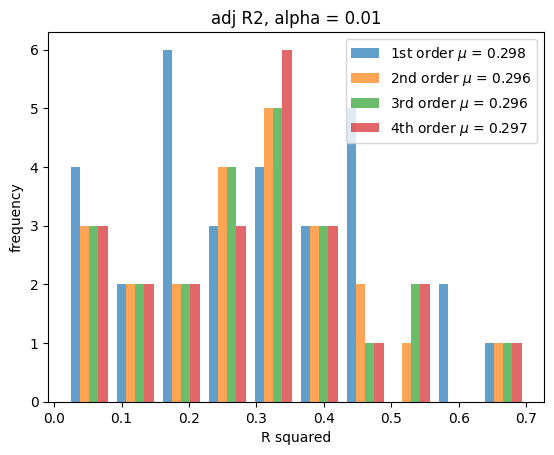

     pseudo_r2  order  drug
0     0.020456      1    53
1     0.020456      2    53
2     0.020456      3    53
3     0.020456      4    53
4     0.100329      1   133
..         ...    ...   ...
107   0.336525      4  2253
108   0.599784      1  2303
109   0.760549      2  2303
110   0.766464      3  2303
111   0.766464      4  2303

[112 rows x 3 columns]
0      0.020456
1      0.020456
2      0.020456
3      0.020456
4      0.100329
         ...   
107    0.336525
108    0.599784
109    0.760549
110    0.766464
111    0.766464
Name: pseudo_r2, Length: 112, dtype: float64


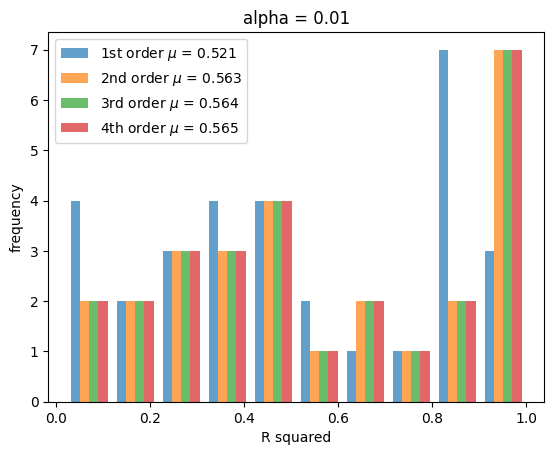

In [51]:
r2_01 = regression_per_drug(proteins, drug_list, 0.01)
r2_hist(r2_01[["adj_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "adj $R^2$, alpha = 0.01", "r2_adj_001")
r2_hist(r2_01[["pseudo_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "alpha = 0.01", "r2_001")

In [58]:
del r2_01

error in OLS, drug  3
error in OLS, drug  53
error in OLS, drug  63
error in OLS, drug  83
error in OLS, drug  133
error in OLS, drug  163
error in OLS, drug  203
error in OLS, drug  253
error in OLS, drug  273
error in OLS, drug  303
error in OLS, drug  333
error in OLS, drug  1003
error in OLS, drug  1013
error in OLS, drug  1033
error in OLS, drug  1053
error in OLS, drug  1073
error in OLS, drug  1083
error in OLS, drug  1093
error in OLS, drug  1143
error in OLS, drug  1193
error in OLS, drug  1373
error in OLS, drug  1563
error in OLS, drug  1853
error in OLS, drug  1873
error in OLS, drug  1873
error in OLS, drug  1873
error in OLS, drug  1913
error in OLS, drug  1923
error in OLS, drug  1933
error in OLS, drug  1973
error in OLS, drug  1993
error in OLS, drug  1993
error in OLS, drug  1993
error in OLS, drug  2023
error in OLS, drug  2043


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

error in OLS, drug  2153
error in OLS, drug  2163
error in OLS, drug  2173
error in OLS, drug  2273
error in OLS, drug  2273
error in OLS, drug  2273


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

error in OLS, drug  2293
error in OLS, drug  2293
error in OLS, drug  2293
error in OLS, drug  2333


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

error in OLS, drug  2463
error in OLS, drug  2503
       adj_r2  order  drug
0    0.050753      1   153
1    0.050753      2   153
2    0.050753      3   153
3    0.050753      4   153
4    0.127558      1   173
..        ...    ...   ...
159  0.473830      4  2323
160  0.535317      1  2363
161       NaN      2  2363
162       NaN      3  2363
163       NaN      4  2363

[164 rows x 3 columns]
0      0.050753
1      0.050753
2      0.050753
3      0.050753
4      0.127558
         ...   
159    0.473830
160    0.535317
161         NaN
162         NaN
163         NaN
Name: adj_r2, Length: 164, dtype: float64


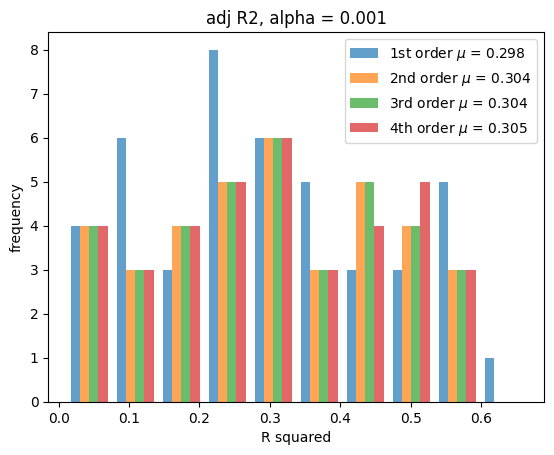

     pseudo_r2  order  drug
0     0.052984      1   153
1     0.052984      2   153
2     0.052984      3   153
3     0.052984      4   153
4     0.170294      1   173
..         ...    ...   ...
159   0.933442      4  2323
160   0.897719      1  2363
161   1.000000      2  2363
162   1.000000      3  2363
163   1.000000      4  2363

[164 rows x 3 columns]
0      0.052984
1      0.052984
2      0.052984
3      0.052984
4      0.170294
         ...   
159    0.933442
160    0.897719
161    1.000000
162    1.000000
163    1.000000
Name: pseudo_r2, Length: 164, dtype: float64


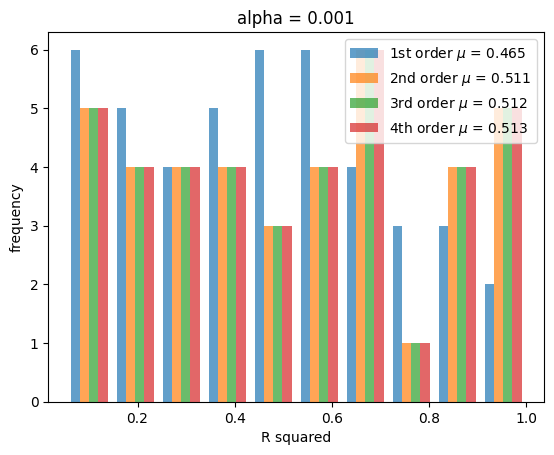

In [52]:
r2_001 = regression_per_drug(proteins, drug_list, 0.001)
r2_hist(r2_001[["adj_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "adj $R^2$, alpha = 0.001", "r2_adj_0001")
r2_hist(r2_001[["pseudo_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "alpha = 0.001", "r2_0001")

In [57]:
del r2_001

In [64]:
del r2_5

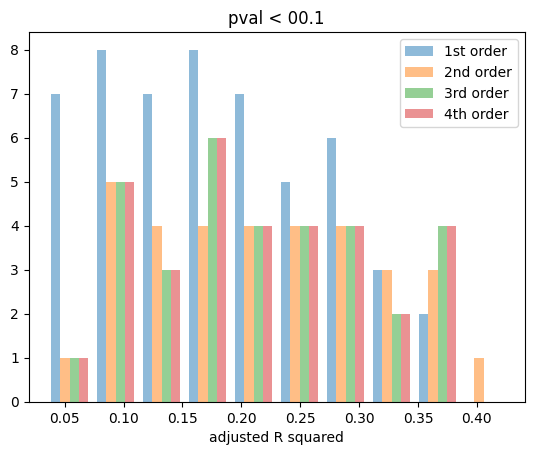

In [132]:
pv_01 = final_results[final_results["P>|z|"] < 0.001][["adj_r2", "order", "drug"]]
pv_01 = pv_01.drop_duplicates().reset_index()

fig, ax = plt.subplots()

ax.hist([pv_01.adj_r2[pv_01.order == 1], pv_01.adj_r2[pv_01.order == 2], pv_01.adj_r2[pv_01.order == 3], pv_01.adj_r2[pv_01.order == 4]], bins=10, alpha=0.5)
# ax.hist(coef_05.adj_r2[coef_05.order == 2], bins=10, alpha=0.5)
# ax.hist(coef_05.adj_r2[coef_05.order == 3], bins=10, alpha=0.5)
# ax.hist(coef_05.adj_r2[coef_05.order == 4], bins=10, alpha=0.5)
# ax.hist(order_max, bins=10, alpha=0.5)

ax.legend(["1st order", "2nd order", "3rd order", "4th order"])
ax.set_xlabel("adjusted R squared")
ax.set_title("pval < 0.001")
plt.savefig("r_squared_001")
plt.show()

In [41]:
xy[["lnICfa"]+ sig_prot.to_list()].dropna(axis=1)  #.fillna(0)

,lnICfa,OaadadEIFdFHUMAN,PfbfhbSSRDHUMAN,PcdciePPIBHUMAN,PdaaieECHMHUMAN,PahhdhPROFbHUMAN,PfbfhbSSRDHUMAN,PgaiggRScaHUMAN,PeddahSSRAHUMAN,PgaiggRScaHUMAN,PeddahSSRAHUMAN
0,-2.596299,5.299368,6.207410,9.526391,7.639382,8.985758,6.207410,8.482296,6.994839,8.482296,6.994839
1,2.682718,6.524248,5.841321,8.752395,7.297391,9.212573,5.841321,9.547826,7.691258,9.547826,7.691258
2,1.792112,5.727289,6.560102,9.905613,7.921472,8.847373,6.560102,8.416462,7.557036,8.416462,7.557036
3,3.325076,6.391359,6.522409,9.698174,6.947134,10.520344,6.522409,8.975344,7.465841,8.975344,7.465841
4,3.395436,6.204334,6.326793,9.270912,7.506969,9.172315,6.326793,8.821580,7.878889,8.821580,7.878889
...,...,...,...,...,...,...,...,...,...,...,...
371,2.599436,6.786067,6.007970,8.092990,6.336561,10.460599,6.007970,8.500930,7.082972,8.500930,7.082972
372,2.725202,6.637676,5.736204,8.944739,5.447825,9.903747,5.736204,9.076092,6.977018,9.076092,6.977018
373,2.926089,6.345729,7.156034,9.218188,6.876047,8.957524,7.156034,8.882528,7.847713,8.882528,7.847713
374,1.923064,6.656712,5.094849,8.032668,6.090132,11.715364,5.094849,9.251311,6.267103,9.251311,6.267103


In [43]:
data = xy[["lnICfa"]+ sig_prot.to_list()].fillna(0) 
ols = smf.ols(formular, data=data)

In [44]:
ols.raise_on_perfect_prediction = False #preventing the perfect separation error
results = ols.fit(disp=False, maxiter=1000) #method prevents singular matrix

In [45]:
results.pvalues.tolist()

[0.2875911025572306,
 0.03799247754914378,
 0.6432220637800747,
 0.39652398474107986,
 0.39652398474093975,
 0.7412646431563563,
 0.2333967133299753,
 0.004396928660540331,
 0.9701296395537482,
 0.023218788712637307,
 0.09237879230965919,
 0.5757342047403629,
 0.10040723858809793,
 0.9700775618832276,
 0.9700775618826719,
 0.6289878579918553,
 0.8533966662747936,
 0.8533966662747994,
 0.35802304691038833,
 0.35802304691039344,
 0.5692358779915352,
 0.6835441371872024,
 0.40626244362700636,
 0.01128089295266969,
 0.12445651256560117,
 0.27397187971685977,
 0.7138423491617896,
 0.5436926189200648,
 0.2599306977680779]

In [46]:
results.rsquared

0.15264191578749653

In [47]:
formular = "lnICfa" + " ~ "
formular = formular + " + ".join(sig_inter)
formular

'lnICfa ~ QiWUdjMZBbHUMAN + QiWUdjMZBbHUMAN:QjNSKaKLCeHUMAN + QbegjgMESDHUMAN:QjgKCiDNJCbHUMAN + OaadadEIFdFHUMAN + PfbfhbSSRDHUMAN + OaadadEIFdFHUMAN:PfbfhbSSRDHUMAN + QjHBHfRDHbeHUMAN + PfgfefCTBPcHUMAN:QjUHVjPFDcHUMAN + PcdciePPIBHUMAN + PeihcdHSPbdHUMAN + PcdciePPIBHUMAN:PeihcdHSPbdHUMAN + PdaaieECHMHUMAN + PgcjihRLeaHUMAN + PgcjihRLeaHUMAN:QjjfjaSCAFBHUMAN + QbdajiCSNbHUMAN + QbdajiCSNbHUMAN:QjULegPSMEcHUMAN + PahhdhPROFbHUMAN + QjUNLcSSRGHUMAN + PahhdhPROFbHUMAN:QjUNLcSSRGHUMAN + QabegjFABPfHUMAN + QchJibINFcHUMAN + PfbfhbSSRDHUMAN + PgaiggRScaHUMAN + PfbfhbSSRDHUMAN:PgaiggRScaHUMAN + PeddahSSRAHUMAN + PgaiggRScaHUMAN + PedcegMSHcHUMAN + PedcegMSHcHUMAN:PgaiggRScaHUMAN + PeddahSSRAHUMAN + QjBYTiNEULHUMAN + QfEBLiPDZbbHUMAN + QaagbaCLHbHUMAN:QfEBLiPDZbbHUMAN + PbbebdGgPDHUMAN + QjUQBiBAIPcHUMAN + PbbebdGgPDHUMAN:QjUQBiBAIPcHUMAN + PaihaiRSbhHUMAN:QjULegPSMEcHUMAN + QabegjFABPfHUMAN + PbhdacCXAbHUMAN + PbhdacCXAbHUMAN:QjBYCjRMcaHUMAN + PdgffbHEMgHUMAN + QiWVVjHNRLLHUMAN + PdgffbHEM

In [49]:
ols = smf.ols(formular, data=xy.fillna(0))
ols.raise_on_perfect_prediction = False #preventing the perfect separation error
results = ols.fit(disp=False, maxiter=1000) #method prevents singular matrix
results.rsquared

0.2273644992798164

In [36]:
results.pvalues.tolist()

[0.13627005944395346,
 0.17096696493785937,
 0.004552575476858089,
 0.0014076224641688783,
 0.016291889376011896,
 0.03057291660545049,
 0.012672719681573519,
 0.19296057997263535]